# Training with MNIST

In this notebook we will make a simple CNN and train fashion MNIST with it. Fashion MNIST is like number MNIST, instead of numbers it has got images of wearables. The classes in Fashion MNIST are

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

In [1]:
#This segment verifies the setup
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"



# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

IS_COLAB=0
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

No GPU was detected. CNNs can be very slow without a GPU.


We will do the following in this section
- Load mnist data from Keras with train_full and test sets
- Create train set and valid set
- Normalise the input data
- Add channel dimension to input

Shape of full train and test sets (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
item0 9
Shape of train and valid sets (25000, 28, 28) (25000,) (5000, 28, 28) (5000,)
Shape of features (25000, 28, 28, 1) (5000, 28, 28, 1) (10000, 28, 28, 1)


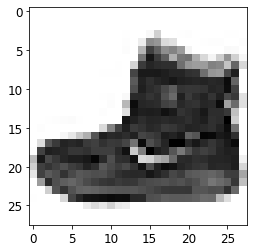

In [2]:

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
print ("Shape of full train and test sets", X_train_full.shape, y_train_full.shape, X_test.shape, y_test.shape)
X_train, X_valid = X_train_full[:-35000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-35000], y_train_full[-5000:]

plt.imshow(X_train_full[0], cmap="Greys")
print ("item0", y_train_full[0])
print ("Shape of train and valid sets", X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

#Normalise the features set with mean and standard deviations
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

#Add an extra dimension for channels and compatibility to tools
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print ("Shape of features", X_train.shape, X_valid.shape, X_test.shape)

- Image is 28x28 and has a single channel
- MaxPooling of 2 reduces spacial dimension by 2 keeping memory requirements in control
- Increase the number of filters (doubling)as we go deeper to create combine lower level feature to higher level features
- We flatten the data and feed to the dense layers in the end. Makes it into a single dimensional array that can be input to dense layers
- There is 50% normalisation to reduce overfitting
- And finally a 10 output dense layer with softmax to bring it down to 10 


In [3]:
from functools import partial

#Create a function with which we can more easily add convolution layers
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]), #Based on input size
    keras.layers.MaxPooling2D(pool_size=2), #Same maxpooling applied regularly
    DefaultConv2D(filters=128),  
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [4]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)

Train on 25000 samples, validate on 5000 samples
Epoch 1/2
25000/25000 [==============================] - 63s 3ms/sample - loss: 0.9632 - accuracy: 0.6577 - val_loss: 0.5330 - val_accuracy: 0.8158
Epoch 2/2
10000/10000 [==============================] - 8s 758us/sample - loss: 0.4003 - accuracy: 0.8555


In [5]:
print (score)

[0.4003287184238434, 0.8555]


In [12]:
X_new = X_test[10:20] # pretend we have new images
y_pred = model.predict(X_new)

In [13]:
#Print actual data from test
print (y_test[10:20])

[4 5 7 3 4 1 2 4 8 0]


In [14]:
#Print the output of the predicted set
print (np.argmax(y_pred, axis=1))

[4 5 5 3 4 1 2 4 8 0]
